### This code (in progress) will calculate the shallow ice approximation (SIA) velocities for a specific ice rise

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import ticker, cm


In [8]:
# Read in bed, grounding line, ice surface and velocity data

data_bed = pd.read_csv('../data/HIR_BedElevation_Bedmachine.csv', delimiter=' ')
data_GL = pd.read_csv('../data/HIR_GL.csv', delim_whitespace=True)
data_surf = pd.read_csv('../data/HIR_SurfaceElevation_REMA.csv', delimiter=' ')
data_vel = pd.read_csv('../data/HIR_SurfaceVelocity.csv', delim_whitespace=True)

In [9]:
# Reduce the number of data points for the surface for computational efficiency. 
# The plan is to run the code on the cluster using all data points

data_surf = data_surf.iloc[::100, :]
data_surf = data_surf.reset_index()


In [10]:
# Reduce the grounding line file to only include relevant data points

data_GL_reduced = data_GL.loc[56:141]

# Add an extra data point in the domain corner and create polygon

new_row = pd.DataFrame({'X':data_GL['X'][56], 'Y':data_GL['Y'][141]}, index=[0])
data_GL_reduced_extra_point = pd.concat([new_row,data_GL_reduced.loc[:]]).reset_index(drop=True)
poly = Polygon(zip(list(data_GL_reduced_extra_point['X']), list(data_GL_reduced_extra_point['Y'])))


In [11]:
# Choose domain coordinates, create regular grid and interpolate unstructured data onto regular grid

xmin, xmax = 770000, 825000
ymin, ymax = 1960000, 2020000
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)

# Grid surface and bed onto regular grid. Will try a higher order method once everything is working
surf = scipy.interpolate.griddata((data_surf["X"], data_surf["Y"]), data_surf["surf"], (grid_x, grid_y), method='linear')
bed = scipy.interpolate.griddata((data_bed["X"], data_bed["Y"]), data_bed["Z"], (grid_x, grid_y), method='linear')

height = surf - bed


In [12]:
# Make a copy of the above array and set all value to zero
slope_x = np.zeros_like(surf)
slope_y = np.zeros_like(surf)

# Code to calculate slope at each node (find slope between previous and next point)

I = len(slope_x)
J = len(slope_x[0])
for i in range(1, I-1):
    for j in range(1, J-1):
        z10 = surf[i-1][j]
        z12 = surf[i+1][j]
        z01 = surf[i][j-1]
        z21 = surf[i][j+1]
        slope_x[i][j] = (z21 - z01)/(dist*2)
        slope_y[i][j] = (z12 - z10)/(dist*2)
        

In [13]:
# Calculate SIA for each point

A, rho, g, n = 4.6e-25, 910.0, 9.81, 3

vel_x = np.zeros_like(surf)
vel_y = np.zeros_like(surf)

for i in range(1, I-1):
    for j in range(1, J-1):
        grad2 = (slope_x[i][j]**2 + slope_y[i][j]**2)**((n-1.0)/2.0)
        vel_x[i][j] = -((rho*g)**3.0)*(A/2) * slope_x[i][j] * grad2 * (height[i][j]**4)
        vel_y[i][j] = -((rho*g)**3.0)*(A/2) * slope_y[i][j] * grad2 * (height[i][j]**4)

vel_x = vel_x * (365.25*24*60*60)
vel_y = vel_y * (365.25*24*60*60)


In [35]:
# Calculate horizontal strain rate tensor at each node

exx = np.zeros_like(surf)
eyy = np.zeros_like(surf)
exy = np.zeros_like(surf)

for i in range(1, I-1):
    for j in range(1, J-1):
        exx[i][j] = (vel_x[i][j+1] - vel_x[i][j-1])/(dist*2)
        eyy[i][j] = (vel_y[i+1][j] - vel_y[i-1][j])/(dist*2)
        exy[i][j] = 0.5*((vel_y[i][j+1] - vel_y[i][j-1])/(dist*2) \
                       + (vel_x[i+1][j] - vel_x[i-1][j])/(dist*2))


In [ ]:
# Calculate 





In [14]:
# Make array with velocity magnitudes

vel_mag = np.zeros_like(surf)

for i in range(1, I-1):
    for j in range(1, J-1):
        vel_mag[i][j] = np.sqrt(vel_x[i][j]**2 + vel_y[i][j]**2)


In [15]:
# Remove data points outside of polygon

for i in range(len(x)):
    for j in range(len(y)):
        boolean = poly.contains(Point(x[i], y[j]))
        if boolean == False:
            surf[j][i] = "nan"
            vel_mag[j][i] = "nan"
            vel_x[j][i] = "nan"
            vel_y[j][i] = "nan"



In [16]:
# Divide velocities by their magnitude for normalised vectors

#vel_x = vel_x / vel_mag
#vel_y = vel_y / vel_mag

vel_x_norm = np.divide(vel_x, vel_mag, out=np.zeros_like(vel_x), where=vel_mag!=0)
vel_y_norm = np.divide(vel_y, vel_mag, out=np.zeros_like(vel_y), where=vel_mag!=0)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_6708/2141164825.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  CS = ax.contourf(grid_x, grid_y, vel_mag, levels=levels, cmap=plt.cm.YlOrRd, locator=ticker.LogLocator(), extend='max')


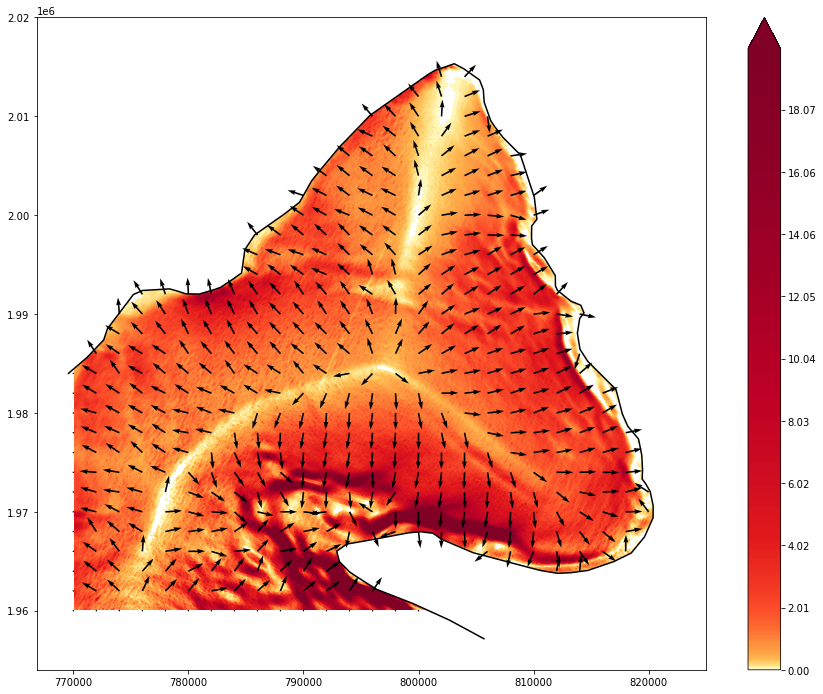

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
levels = np.linspace(0,20.04,500)
CS = ax.contourf(grid_x, grid_y, vel_mag, levels=levels, cmap=plt.cm.YlOrRd, locator=ticker.LogLocator(), extend='max')
#CS = ax.contourf(grid_x, grid_y, vel_mag, levels=levels, cmap=plt.cm.YlOrRd)
#CS = ax.contourf(grid_x, grid_y, vel_mag, 100)

skip = (slice(None, None, 20), slice(None, None, 20))
ax.quiver(grid_x[skip], grid_y[skip], vel_x_norm[skip], vel_y_norm[skip], scale=40)
ax.plot(data_GL_reduced['X'], data_GL_reduced['Y'], color='black')
cbar = fig.colorbar(CS)

# Check log plot?
